# Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import bz2
import json
import matplotlib.pyplot as plt
from processing import *
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from tld import get_tld
#from google.colab import drive
#drive.mount('/content/drive')

#PATH_ROOT = '/content/drive/MyDrive/ADA'
PATH_ROOT = 'data'
PATH_PARQUET = PATH_ROOT + '/project_datasets'
PATH_QUOTEBANK = PATH_ROOT + '/Quotebank'
PATH_TO_QUOTES = PATH_QUOTEBANK + '/quotes-{year}.json.bz2'
PATH_TO_WORDS = PATH_ROOT + '/Keywords'
PATH_TO_ENVIRONMENT_WORDS = PATH_TO_WORDS + "/environment_keywords.txt"
PATH_TO_LGBT_WORDS = PATH_TO_WORDS + "/lgbt_keywords.txt"
PATH_TO_BREXIT_WORDS = PATH_TO_WORDS + "/brexit_keywords.txt"
PATH_TO_DATA_SCIENCE_WORDS = PATH_TO_WORDS + "/data_science_keywords.txt"
PATH_TO_GUN_CONTROL_WORDS = PATH_TO_WORDS + "/gun_control_keywords.txt"

%reload_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', 1000, 'display.max_colwidth', 5000, 'display.max_rows',1000)

---

# Loading the dataset

In [2]:
quotes = pd.read_json(path_or_buf="data/Quotebank/quotes-2019-nytimes.json.bz2", compression='bz2', lines=True)

---
# Plotting the original data

In [3]:
display(quotes.head())

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2019-04-17-024782,"It is not a low-income immigration,",James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q6133913]",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate/house-hunting-in-hong-kong.html?partner=rss&emc=rss],E
1,2019-04-02-001128,a champion figure skater switching to roller skates.,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]","[https://www.nytimes.com/2019/04/02/opinion/vladimir-nabokov-literary-refugee.html?partner=rss&emc=rss, https://nationalpost.com/opinion/robert-fulford-vladimir-nabokovs-remarkable-works-remain-as-powerful-as-ever]",E
2,2019-05-09-055187,It makes it much more difficult for him to make the compromises needed.,None,[],2019-05-09 18:11:29,1,"[[None, 0.6493], [President Bill Clinton, 0.2718], [Xi Jinping, 0.0459], [Melania Trump, 0.033]]",[http://mobile.nytimes.com/2019/05/09/world/asia/xi-jinping-donald-trump.html],E
3,2019-10-31-056366,"It puts me in a predicament,",Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [Steph Curry, 0.0026]]","[http://www.nytimes.com/2019/10/31/technology/tech-investigations-california-attorney-general-becerra.html, http://mobile.sfgate.com/business/article/California-Attorney-General-Is-a-No-Show-on-Tech-14661175.php, http://sfgate.com/business/article/California-Attorney-General-Is-a-No-Show-on-Tech-14661175.php]",E
4,2019-01-04-001792,A Pile of Leaves.,None,[],2019-01-04 10:00:07,1,"[[None, 0.8737], [Jason Fulford, 0.1263]]",[https://www.nytimes.com/2019/01/04/books/review/hug-this-book-barney-saltzberg-fred-benaglia.html],E


# Getting the domain 

In [4]:
quotes["domains"] = quotes["urls"].apply(set_domains)

# Labeling the data

In [5]:
topic_filtering(quotes, "Environment", PATH_TO_ENVIRONMENT_WORDS)
topic_filtering(quotes, "LGBT", PATH_TO_LGBT_WORDS)
topic_filtering(quotes, "Brexit", PATH_TO_BREXIT_WORDS)

/Users/nearchospotamitis/Desktop/ada-2021-project-comic-sans/processing.py:27: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df.loc[df["quotation"].str.contains('|'.join(lines),case = False),column_name]=1


# Question 5 : What is the magnitude of the presence of enviromental quotes compared to other significant topics ?

In [6]:
quotes_env = quotes[quotes["Environment_related"]==1]
quotes_lgb = quotes[quotes["LGBT_related"]==1]
quotes_bre = quotes[quotes["Brexit_related"]==1]

## Total quotes per topic

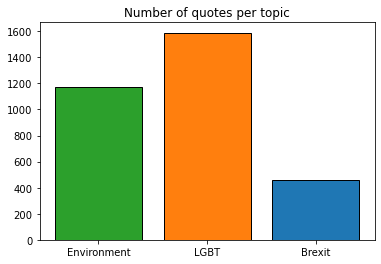

In [7]:
topic_of_quotes = ["Environment", "LGBT", "Brexit"]
number_of_quotes = np.array([quotes_env.shape[0], quotes_lgb.shape[0], quotes_bre.shape[0]])

plot_total = plt.bar(topic_of_quotes, number_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue"])
plt.title("Number of quotes per topic")
plt.show()

## Distributions for each topic

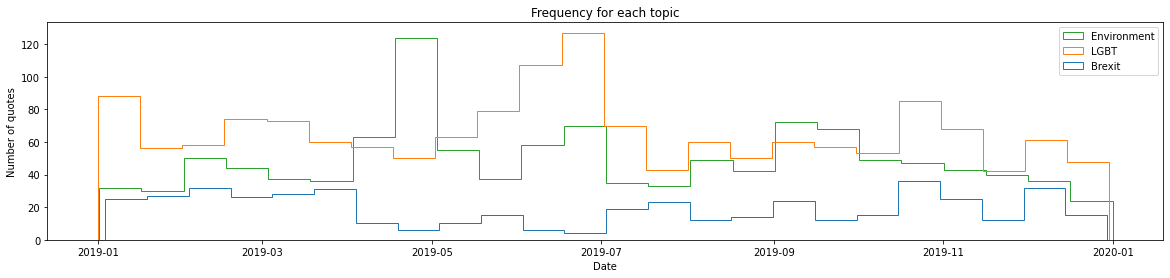

In [8]:
plt.figure(figsize = (20,4))
plt.hist(quotes_env["date"], histtype = "step", label = "Environment", color = "tab:green", bins = 24)
plt.hist(quotes_lgb["date"], histtype = "step", label = "LGBT", color = "tab:orange", bins = 24)
plt.hist(quotes_bre["date"], histtype = "step", label = "Brexit", color = "tab:blue", bins = 24)
plt.xlabel("Date")
plt.ylabel("Number of quotes")
plt.title("Frequency for each topic")
plt.legend()
plt.show()

## Topic Analysis per media source

### 1) New york times

###

In [9]:
def check_domain(domains, media):
    return media in domains

In [10]:
nytimes_quotes = quotes[quotes["domains"].apply(check_domain, args = ("nationalpost",))]
nytimes_quotes_env = nytimes_quotes[nytimes_quotes["Environment_related"]==1]
nytimes_quotes_lgb = nytimes_quotes[nytimes_quotes["LGBT_related"]==1]
nytimes_quotes_bre = nytimes_quotes[nytimes_quotes["Brexit_related"]==1] 

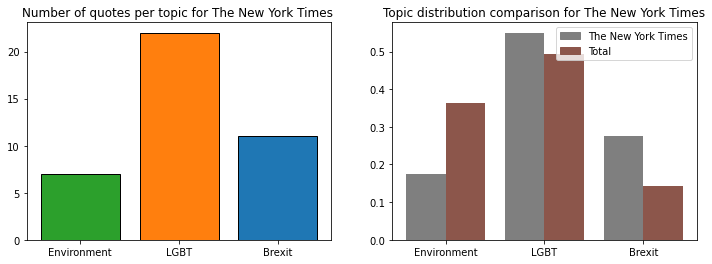

In [11]:
nytimes_number_of_quotes = np.array([nytimes_quotes_env.shape[0], nytimes_quotes_lgb.shape[0], nytimes_quotes_bre.shape[0]])
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.bar(topic_of_quotes, nytimes_number_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue"])
plt.title("Number of quotes per topic for The New York Times ")
plt.subplot(122)
colors = {"The New York Times":'tab:grey', 'Total':'tab:brown'} 
subcategorybar(topic_of_quotes, [nytimes_number_of_quotes, number_of_quotes], colors, media = "The New York Times")
plt.show()

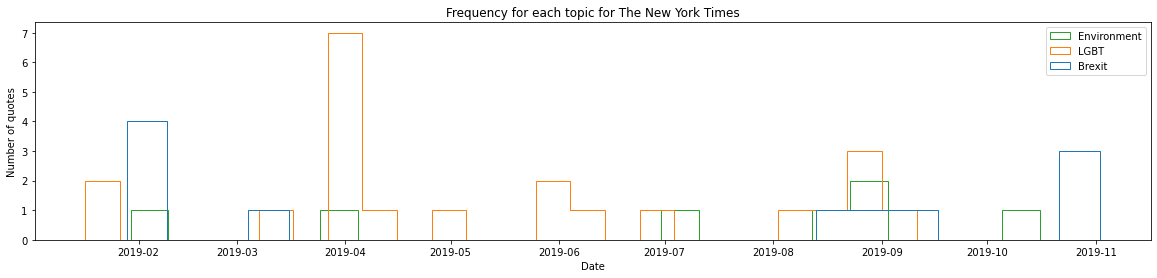

In [12]:
plt.figure(figsize = (20,4))
plt.hist(nytimes_quotes_env["date"], histtype = "step", label = "Environment", color = "tab:green", bins = 24)
plt.hist(nytimes_quotes_lgb["date"], histtype = "step", label = "LGBT", color = "tab:orange", bins = 24)
plt.hist(nytimes_quotes_bre["date"], histtype = "step", label = "Brexit", color = "tab:blue", bins = 24)
plt.xlabel("Date")
plt.ylabel("Number of quotes")
plt.title("Frequency for each topic for The New York Times")
plt.legend()
plt.show()

### 2) The Washington Post

In [13]:
washingtonpost_quotes = quotes[quotes["domains"].apply(check_domain, args = ("washingtonpost",))]
washingtonpost_quotes_env = washingtonpost_quotes[washingtonpost_quotes["Environment_related"]==1]
washingtonpost_quotes_lgb = washingtonpost_quotes[washingtonpost_quotes["LGBT_related"]==1]
washingtonpost_quotes_bre = washingtonpost_quotes[washingtonpost_quotes["Brexit_related"]==1] 

/Users/nearchospotamitis/Desktop/ada-2021-project-comic-sans/processing.py:93: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(_X - width/2. + i/float(n)*width, vals[i]/vals[i].sum(),


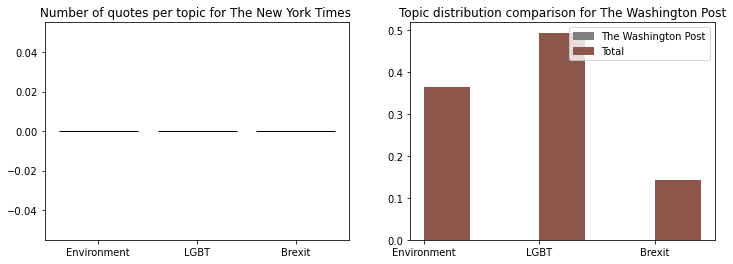

In [14]:
washingtonpost_number_of_quotes = np.array([washingtonpost_quotes_env.shape[0], washingtonpost_quotes_lgb.shape[0], washingtonpost_quotes_bre.shape[0]])
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.bar(topic_of_quotes, washingtonpost_number_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue"])
plt.title("Number of quotes per topic for The New York Times ")
plt.subplot(122)
colors = {"The Washington Post":'tab:grey', 'Total':'tab:brown'} 
subcategorybar(topic_of_quotes, [washingtonpost_number_of_quotes, number_of_quotes], colors, media = "The Washington Post")
plt.show()

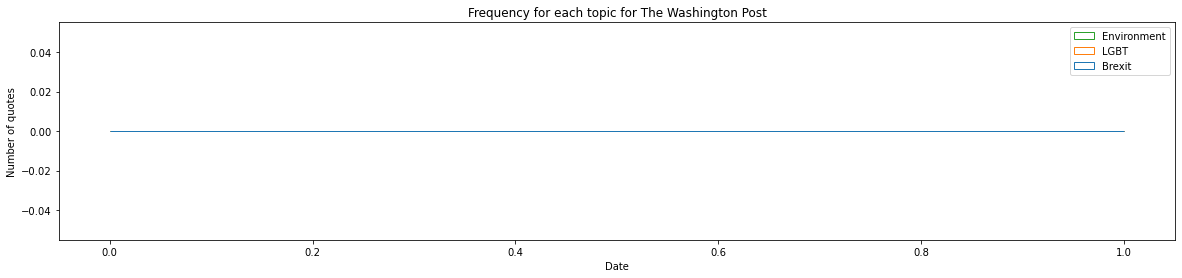

In [15]:
plt.figure(figsize = (20,4))
plt.hist(washingtonpost_quotes_env["date"], histtype = "step", label = "Environment", color = "tab:green", bins = 24)
plt.hist(washingtonpost_quotes_lgb["date"], histtype = "step", label = "LGBT", color = "tab:orange", bins = 24)
plt.hist(washingtonpost_quotes_bre["date"], histtype = "step", label = "Brexit", color = "tab:blue", bins = 24)
plt.xlabel("Date")
plt.ylabel("Number of quotes")
plt.title("Frequency for each topic for The Washington Post")
plt.legend()
plt.show()

### 3) The Guardian

In [16]:
theguardian_quotes = quotes[quotes["domains"].apply(check_domain, args = ("theguardian",))]
theguardian_quotes_env = theguardian_quotes[theguardian_quotes["Environment_related"]==1]
theguardian_quotes_lgb = theguardian_quotes[theguardian_quotes["LGBT_related"]==1]
theguardian_quotes_bre = theguardian_quotes[theguardian_quotes["Brexit_related"]==1] 

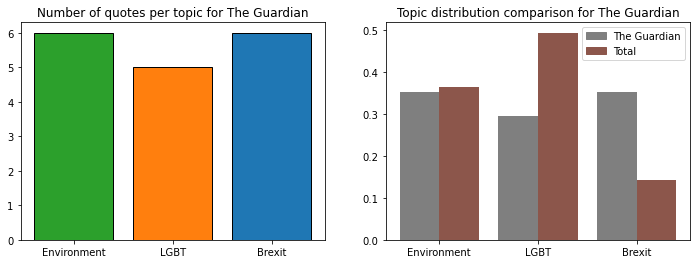

In [17]:
theguardian_number_of_quotes = np.array([theguardian_quotes_env.shape[0], theguardian_quotes_lgb.shape[0], theguardian_quotes_bre.shape[0]])
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.bar(topic_of_quotes, theguardian_number_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue"])
plt.title("Number of quotes per topic for The Guardian")
plt.subplot(122)
colors = {"The Guardian":'tab:grey', 'Total':'tab:brown'} 
subcategorybar(topic_of_quotes, [theguardian_number_of_quotes, number_of_quotes], colors, media = "The Guardian")
plt.show()

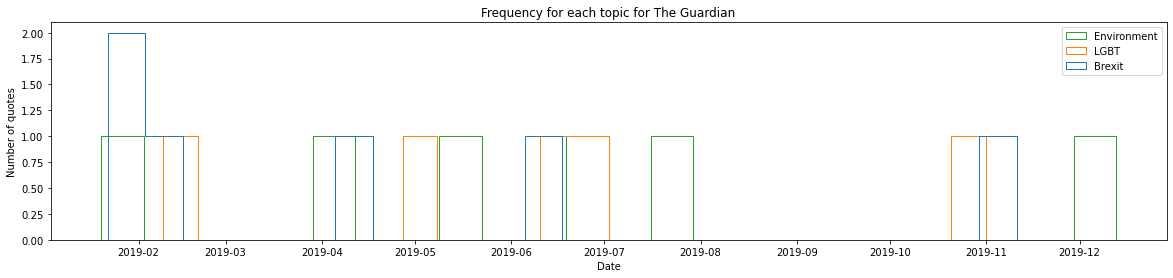

In [18]:
plt.figure(figsize = (20,4))
plt.hist(theguardian_quotes_env["date"], histtype = "step", label = "Environment", color = "tab:green", bins = 24)
plt.hist(theguardian_quotes_lgb["date"], histtype = "step", label = "LGBT", color = "tab:orange", bins = 24)
plt.hist(theguardian_quotes_bre["date"], histtype = "step", label = "Brexit", color = "tab:blue", bins = 24)
plt.xlabel("Date")
plt.ylabel("Number of quotes")
plt.title("Frequency for each topic for The Guardian")
plt.legend()
plt.show()

### 4) The Wall Street Journal

In [19]:
wsj_quotes = quotes[quotes["domains"].apply(check_domain, args = ("wsj",))]
wsj_quotes_env = wsj_quotes[wsj_quotes["Environment_related"]==1]
wsj_quotes_lgb = wsj_quotes[wsj_quotes["LGBT_related"]==1]
wsj_quotes_bre = wsj_quotes[wsj_quotes["Brexit_related"]==1] 

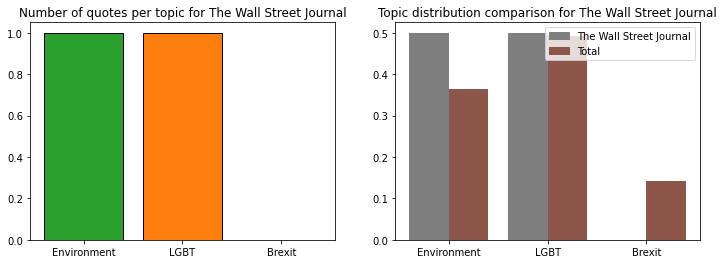

In [20]:
wsj_number_of_quotes = np.array([wsj_quotes_env.shape[0], wsj_quotes_lgb.shape[0], wsj_quotes_bre.shape[0]])
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.bar(topic_of_quotes, wsj_number_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue"])
plt.title("Number of quotes per topic for The Wall Street Journal")
plt.subplot(122)
colors = {"The Wall Street Journal":'tab:grey', 'Total':'tab:brown'} 
subcategorybar(topic_of_quotes, [wsj_number_of_quotes, number_of_quotes], colors, media = "The Wall Street Journal")
plt.show()

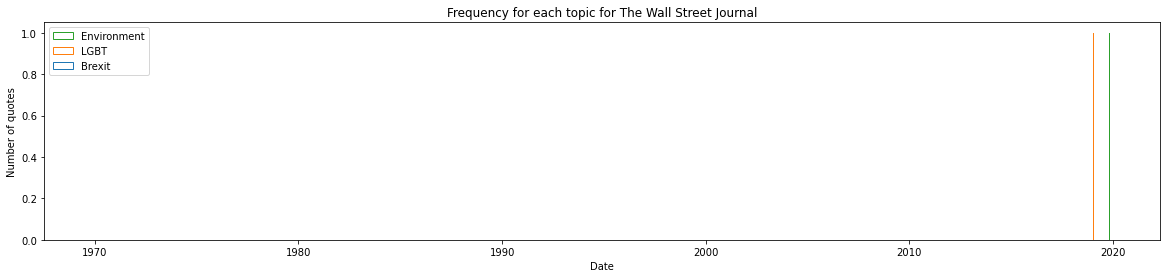

In [21]:
plt.figure(figsize = (20,4))
plt.hist(wsj_quotes_env["date"], histtype = "step", label = "Environment", color = "tab:green", bins = 24)
plt.hist(wsj_quotes_lgb["date"], histtype = "step", label = "LGBT", color = "tab:orange", bins = 24)
plt.hist(wsj_quotes_bre["date"], histtype = "step", label = "Brexit", color = "tab:blue", bins = 24)
plt.xlabel("Date")
plt.ylabel("Number of quotes")
plt.title("Frequency for each topic for The Wall Street Journal")
plt.legend()
plt.show()

### 5) Bloomberg

In [22]:
bloomberg_quotes = quotes[quotes["domains"].apply(check_domain, args = ("bloomberg",))]
bloomberg_quotes_env = bloomberg_quotes[bloomberg_quotes["Environment_related"]==1]
bloomberg_quotes_lgb = bloomberg_quotes[bloomberg_quotes["LGBT_related"]==1]
bloomberg_quotes_bre = bloomberg_quotes[bloomberg_quotes["Brexit_related"]==1]

/Users/nearchospotamitis/Desktop/ada-2021-project-comic-sans/processing.py:93: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(_X - width/2. + i/float(n)*width, vals[i]/vals[i].sum(),


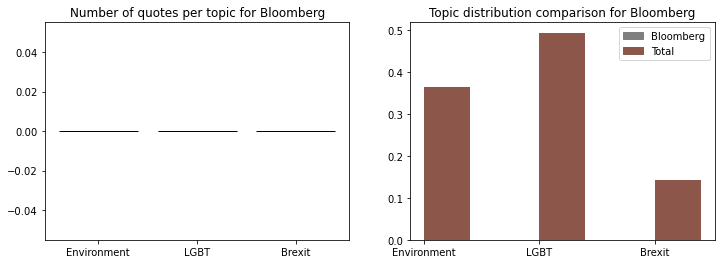

In [23]:
bloomberg_number_of_quotes = np.array([bloomberg_quotes_env.shape[0], bloomberg_quotes_lgb.shape[0], bloomberg_quotes_bre.shape[0]])
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.bar(topic_of_quotes, bloomberg_number_of_quotes,ec = "black", color = ["tab:green", "tab:orange", "tab:blue"])
plt.title("Number of quotes per topic for Bloomberg")
plt.subplot(122)
colors = {"Bloomberg":'tab:grey', 'Total':'tab:brown'} 
subcategorybar(topic_of_quotes, [bloomberg_number_of_quotes, number_of_quotes],colors, media = "Bloomberg")
plt.show()

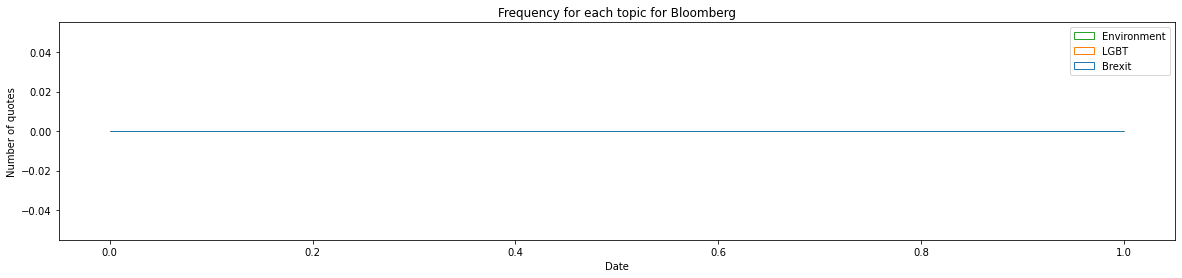

In [24]:
plt.figure(figsize = (20,4))
plt.hist(bloomberg_quotes_env["date"], histtype = "step", label = "Environment", color = "tab:green", bins = 24)
plt.hist(bloomberg_quotes_lgb["date"], histtype = "step", label = "LGBT", color = "tab:orange", bins = 24)
plt.hist(bloomberg_quotes_bre["date"], histtype = "step", label = "Brexit", color = "tab:blue", bins = 24)
plt.xlabel("Date")
plt.ylabel("Number of quotes")
plt.title("Frequency for each topic for Bloomberg")
plt.legend()
plt.show()

### Summary

/Users/nearchospotamitis/Desktop/ada-2021-project-comic-sans/processing.py:93: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(_X - width/2. + i/float(n)*width, vals[i]/vals[i].sum(),


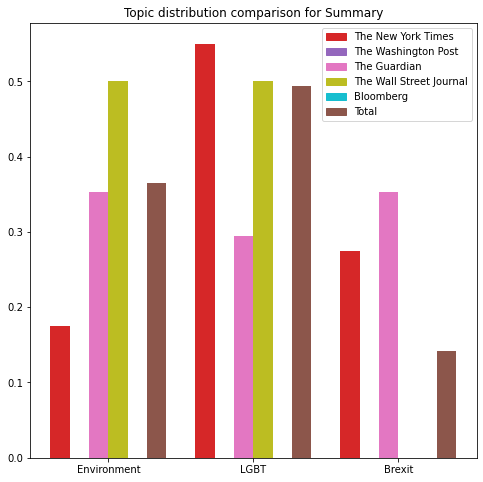

In [25]:
plt.figure(figsize = (8,8))
colors = {"The New York Times":'tab:red', "The Washington Post":'tab:purple', "The Guardian":'tab:pink', 
          "The Wall Street Journal":'tab:olive', "Bloomberg":'tab:cyan', 'Total':'tab:brown'} 
subcategorybar(topic_of_quotes, [nytimes_number_of_quotes, washingtonpost_number_of_quotes, theguardian_number_of_quotes, 
                                 wsj_number_of_quotes, bloomberg_number_of_quotes, number_of_quotes],colors, media = "Summary")
plt.show()

# Wordcloud

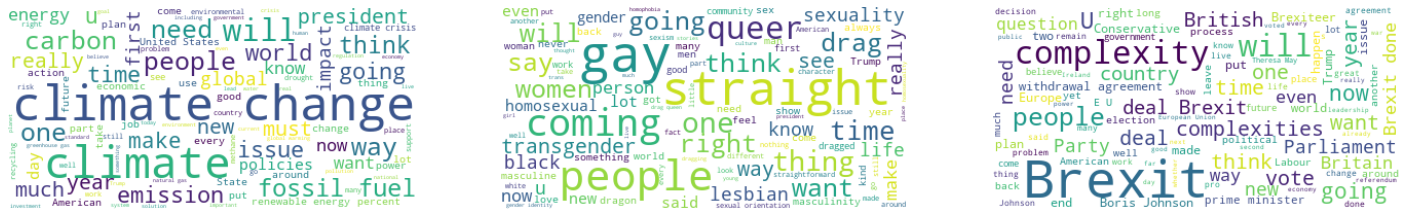

In [26]:
text_env = " ".join(review for review in quotes_env.quotation)
text_lgb = " ".join(review for review in quotes_lgb.quotation)
text_bre = " ".join(review for review in quotes_bre.quotation)

wordcloud_env = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_env)
wordcloud_lgb = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_lgb)
wordcloud_bre = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_bre)

plt.figure(figsize = (25,25))
plt.subplot(131)
plt.imshow(wordcloud_env, interpolation='bilinear')
plt.axis("off")
plt.subplot(132)
plt.imshow(wordcloud_lgb, interpolation='bilinear')
plt.axis("off")
plt.subplot(133)
plt.imshow(wordcloud_bre, interpolation='bilinear')
plt.axis("off")
plt.show()